In [1]:
from typing import Sequence, Callable

import graphinference.libs.qspems_sim_core as qspems_sim_core
from graphinference import inference_methods, metrics

import matplotlib.pyplot as plt
import netrd
import networkx as nx
import numpy as np

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["figure.dpi"] = 300

# Inference Accuracy as Number of Observations Increase

In [2]:
def graph_inf_score_as_obs_incr(
    num_obs_seq: Sequence[int],
    graph_model: Callable[[None], nx.Graph],
    dynamic_model: Callable[[nx.Graph, int], np.ndarray],
    infr_method: Callable[[np.ndarray], np.ndarray],
    metric: Callable[[np.ndarray], np.ndarray]
):
    """Measure the improvement of graph inference with more observations.
    
    Args:
        obs_seq: A sequence of integers representing the number of time
            points to sample.
        graph_model: A zero argument function that generates a network.
        dynamic_model: A two argument function that accepts a network
            and an integer and returns an (mxn) time series where
            m is the number of nodes in the graph and n is the number
            of observations.
        infr_method: A single argument function that accepts a (mxn) time
            series (where m is the number of nodes in the graph and n is the
            number of observations) and returns an (mxm) adjacency matrix.
        metric: A two argument function that accepts two adjacency matrices
            and returns an accuracy score. The first argument is assumed
            to be the ground truth.

    Returns:
        A sequence scores (assesd with `metric`) corresponding to `num_obs_seq` 
        that denotes the effectiveness of the network reconstruction algorithm.
    """
    scores = np.zeros(len(num_obs_seq))
    for i, n in enumerate(num_obs_seq):
        # Make a random graph
        G = graph_model()

        # Generate a stochastic time series of length n
        X = dynamic_model(G, n)
        # Retrieve and store F1 score
        pred_adj = infr_method(X)
        scores[i] = metric(nx.to_numpy_array(G), pred_adj)

    return scores


In [3]:
obs_seq = np.arange(30, 360, 30)
reps = 25

# VAR Simulation

graph_model = lambda: nx.fast_gnp_random_graph(10, .2)
qspems_model1 = lambda G, n: qspems_sim_core.sim(nx.to_numpy_array(G).T, dt=1, T=n)
var_infr = lambda X: inference_methods.vector_autoregression(X)

f1_qs_var_trials1 = [
    graph_inf_score_as_obs_incr(
        obs_seq, graph_model,
        qspems_model1,
        var_infr,
        metrics.compare_adj_f1_score
    )
    for i in range(reps)
]

# Stochastic Difference equation

graph_model = lambda: nx.fast_gnp_random_graph(10, .2)
qspems_model2 = lambda G, n: qspems_sim_core.sim(nx.to_numpy_array(G).T, dt=0.2, T=n)

f1_qs_var_trials2 = [
    graph_inf_score_as_obs_incr(
        obs_seq,
        graph_model,
        qspems_model2,
        var_infr,
        metrics.compare_adj_f1_score
    )
    for i in range(reps)
]

# Branching process model
branching_model_class = netrd.dynamics.BranchingModel()
initial_fraction_active = 0.5
branching_ratio = 0.9
desired_average_activity = 0.1


branch_model = lambda G, n: branching_model_class.simulate(
    G,
    n,
    initial_fraction=initial_fraction_active,
    m =branching_ratio,
    target_Ahat=desired_average_activity,
)

f1_branch_var_trials= [
    graph_inf_score_as_obs_incr(
        obs_seq,
        graph_model,
        branch_model,
        var_infr,
        metrics.compare_adj_f1_score
    )
    for i in range(reps)
]

mean_f1_qs_var1 = np.mean(np.vstack(f1_qs_var_trials1), axis=0)
qs_std1 = np.std(np.vstack(f1_qs_var_trials1), axis=0)

mean_f1_qs_var2 = np.mean(np.vstack(f1_qs_var_trials2), axis=0)
qs_std2 = np.std(np.vstack(f1_qs_var_trials2), axis=0)

mean_f1_branch_var = np.mean(np.vstack(f1_branch_var_trials), axis=0)
branch_std = np.std(np.vstack(f1_branch_var_trials), axis=0)



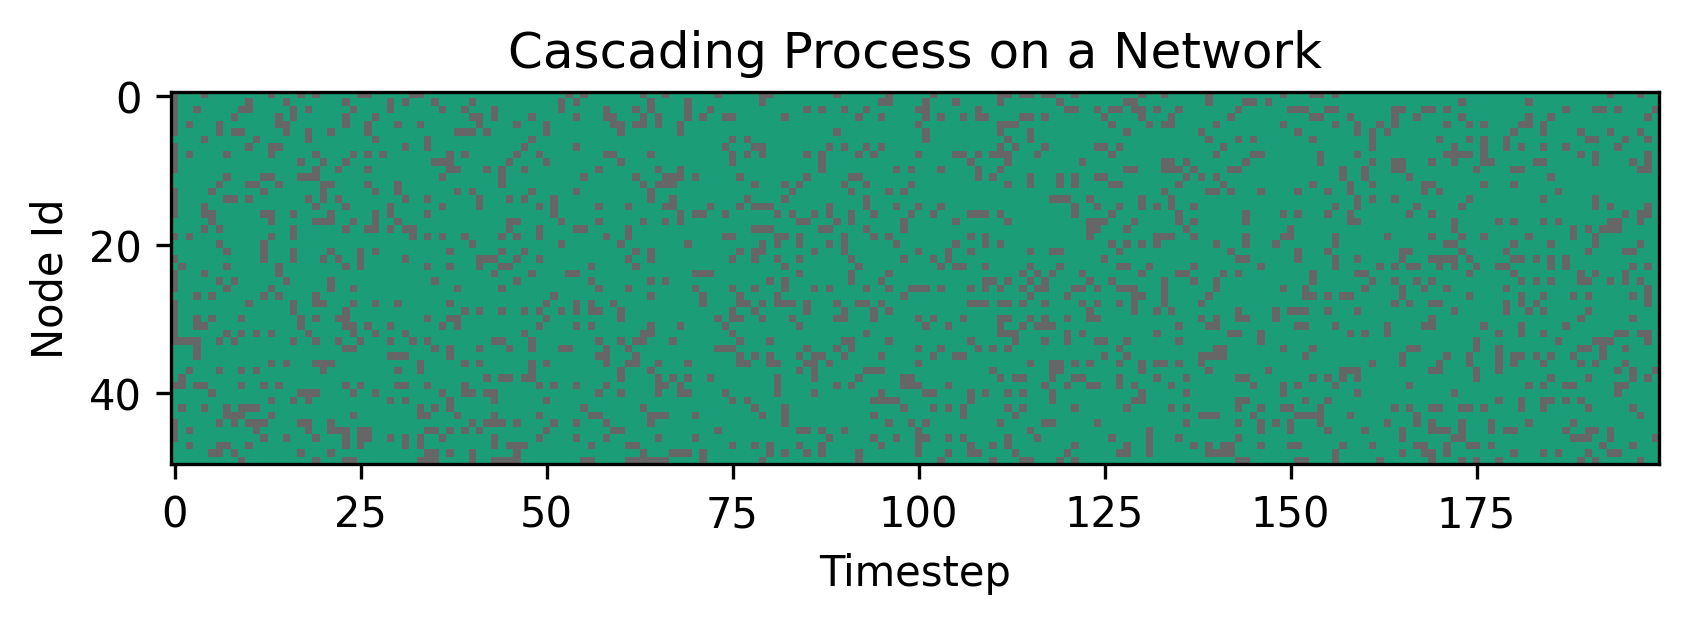

In [4]:
G = nx.fast_gnp_random_graph(50, 3/50)
X = branch_model(G, 200)

plt.imshow(X, cmap="Dark2")
plt.ylabel("Node Id")
plt.xlabel("Timestep")
plt.title("Cascading Process on a Network")
plt.show()

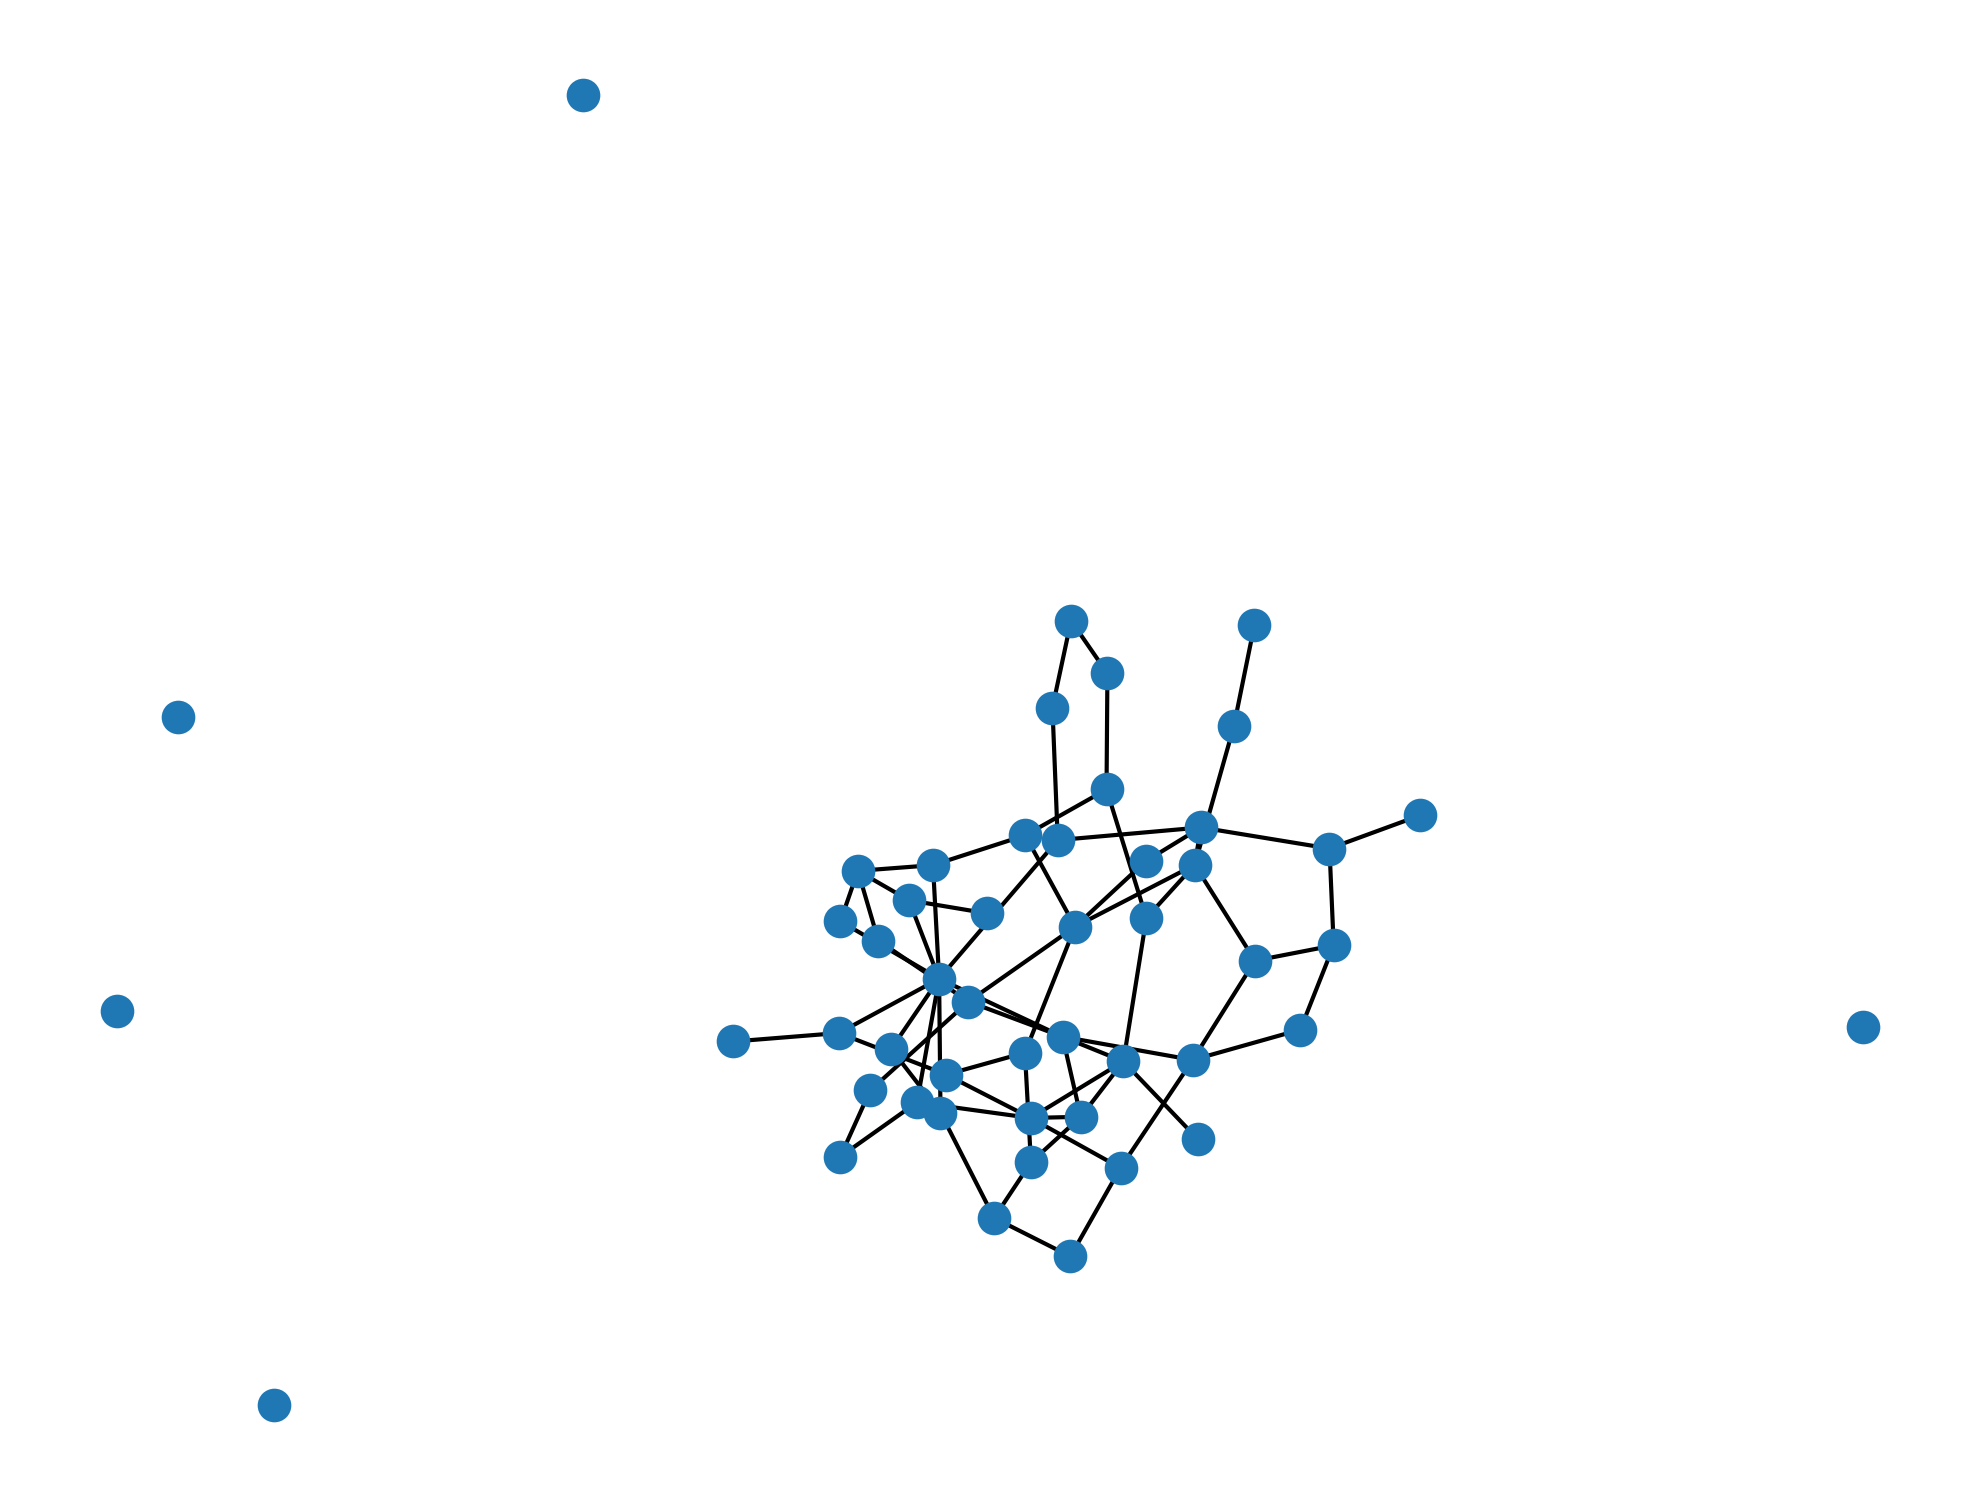

In [5]:
nx.draw(G, node_size=50)

Text(0.5, 1.0, 'VAR Model Dynamics on Network')

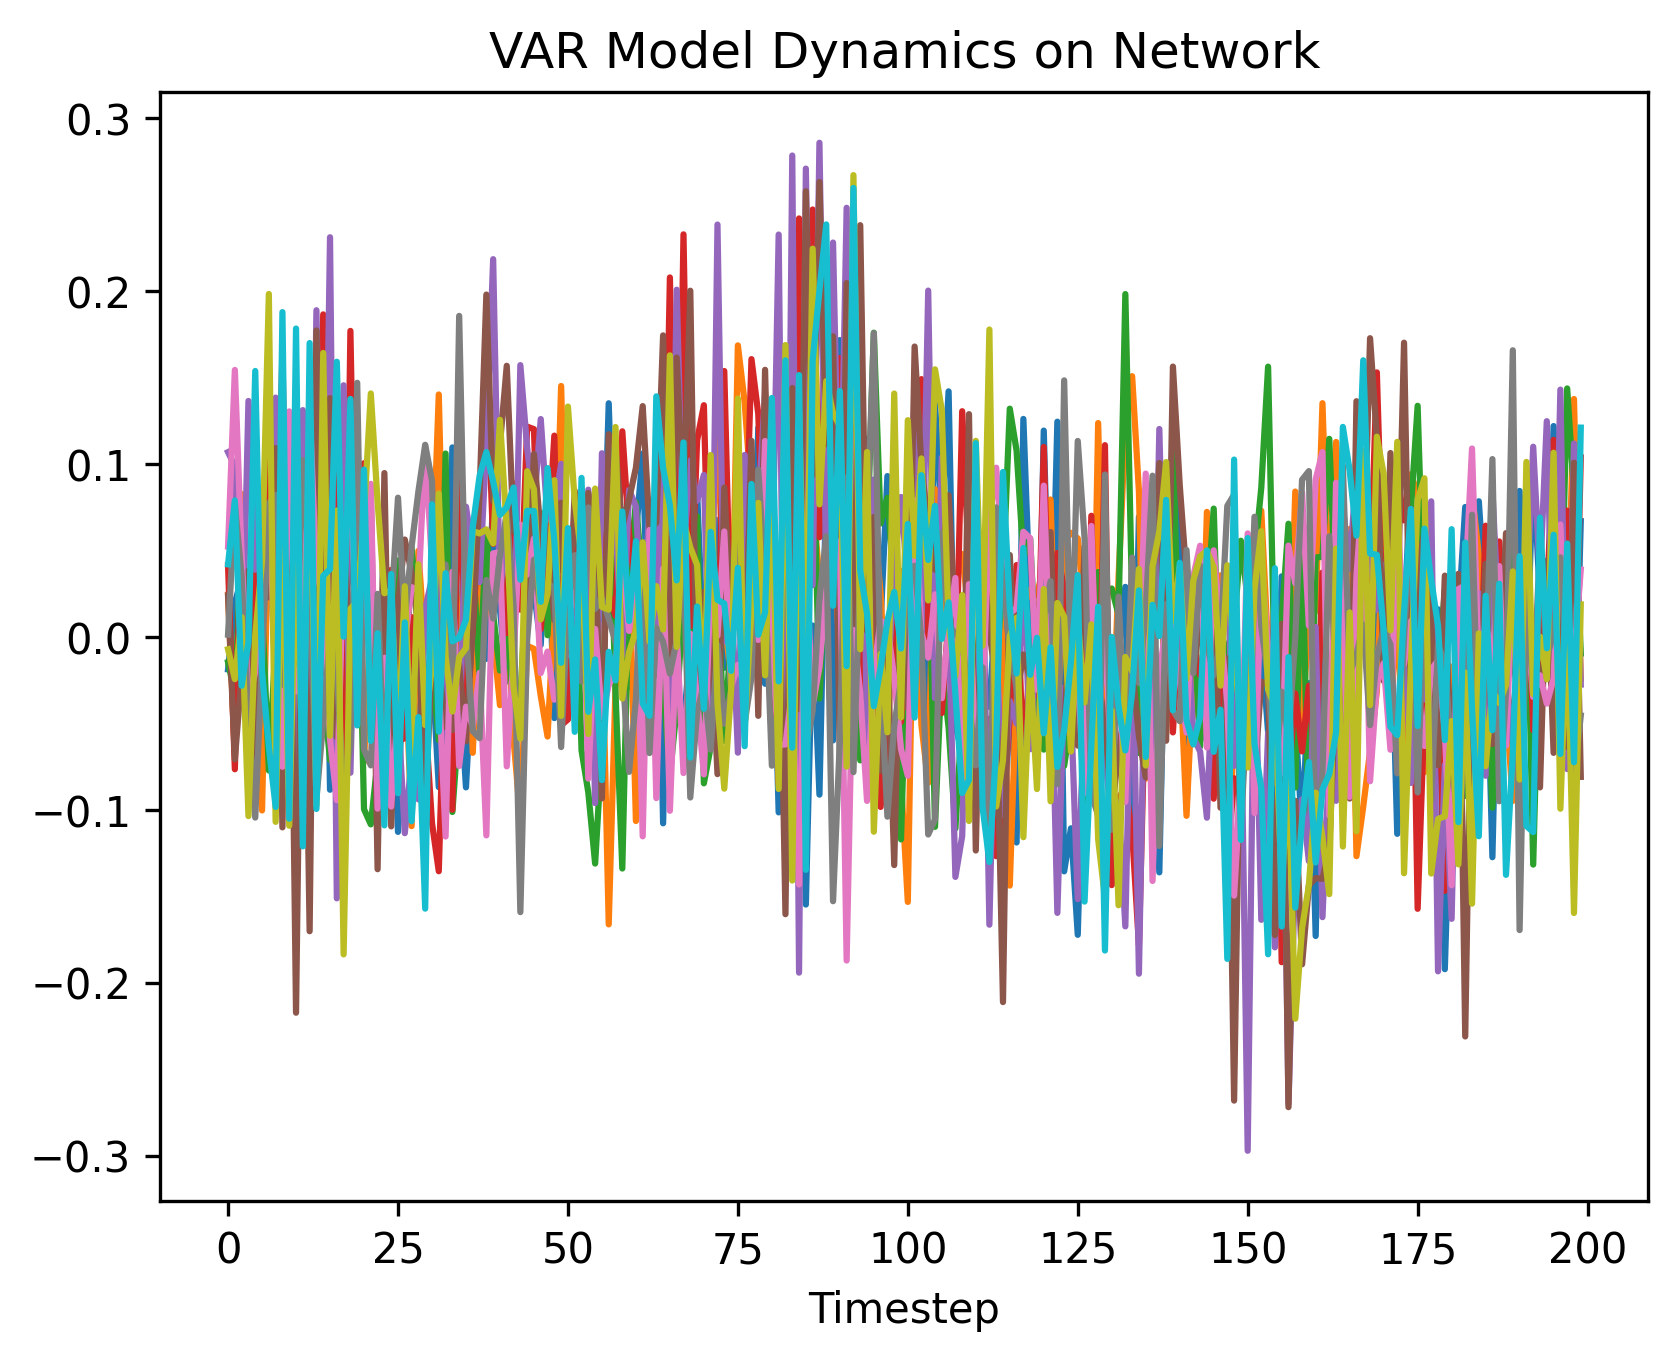

In [6]:
X = qspems_model1(graph_model(), 200)
plt.plot(X.T)
plt.xlabel("Timestep")

plt.title("VAR Model Dynamics on Network")

Text(0.5, 1.0, 'Linear Stochastic Difference Equation on Network')

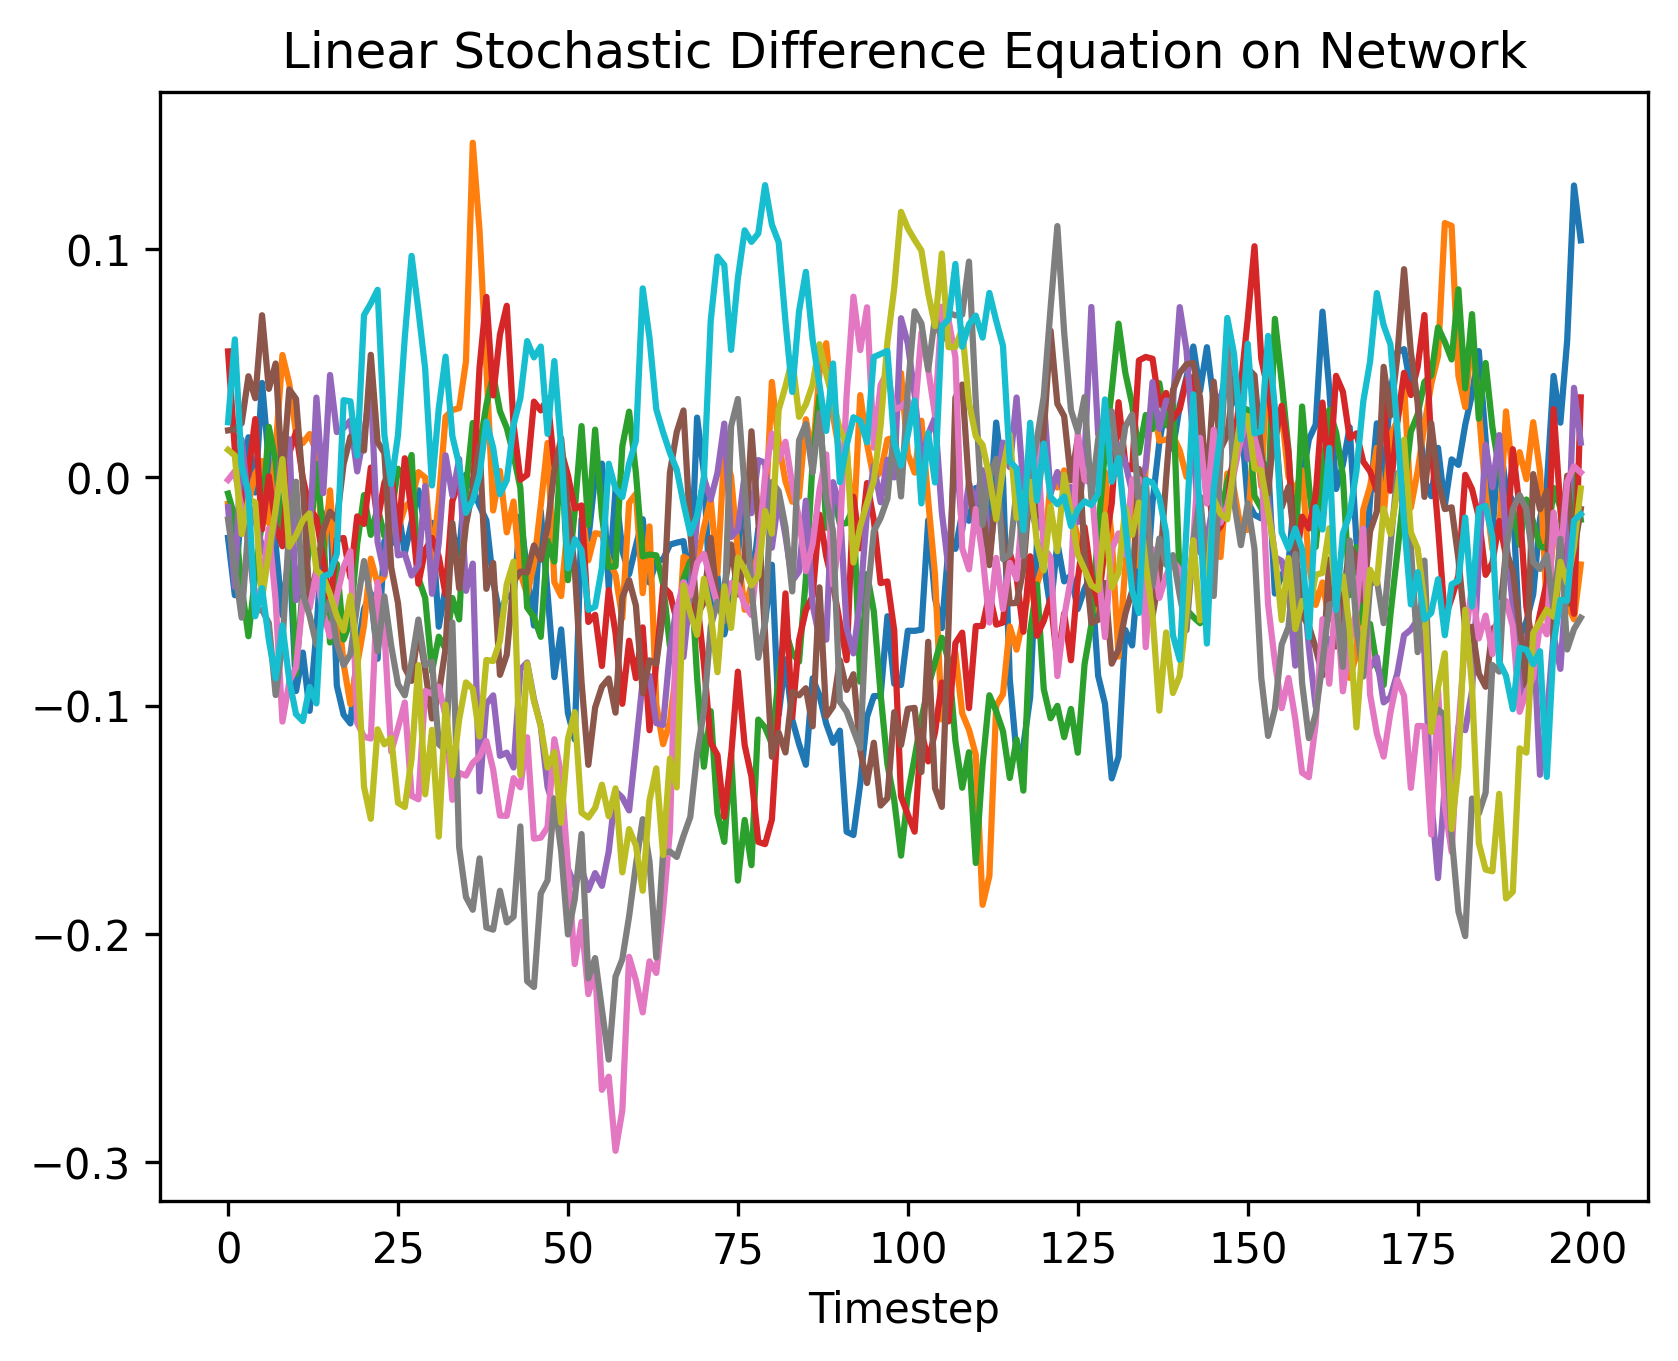

In [7]:
X = qspems_model2(graph_model(), 200)
plt.plot(X.T)
plt.xlabel("Timestep")

plt.title("Linear Stochastic Difference Equation on Network")

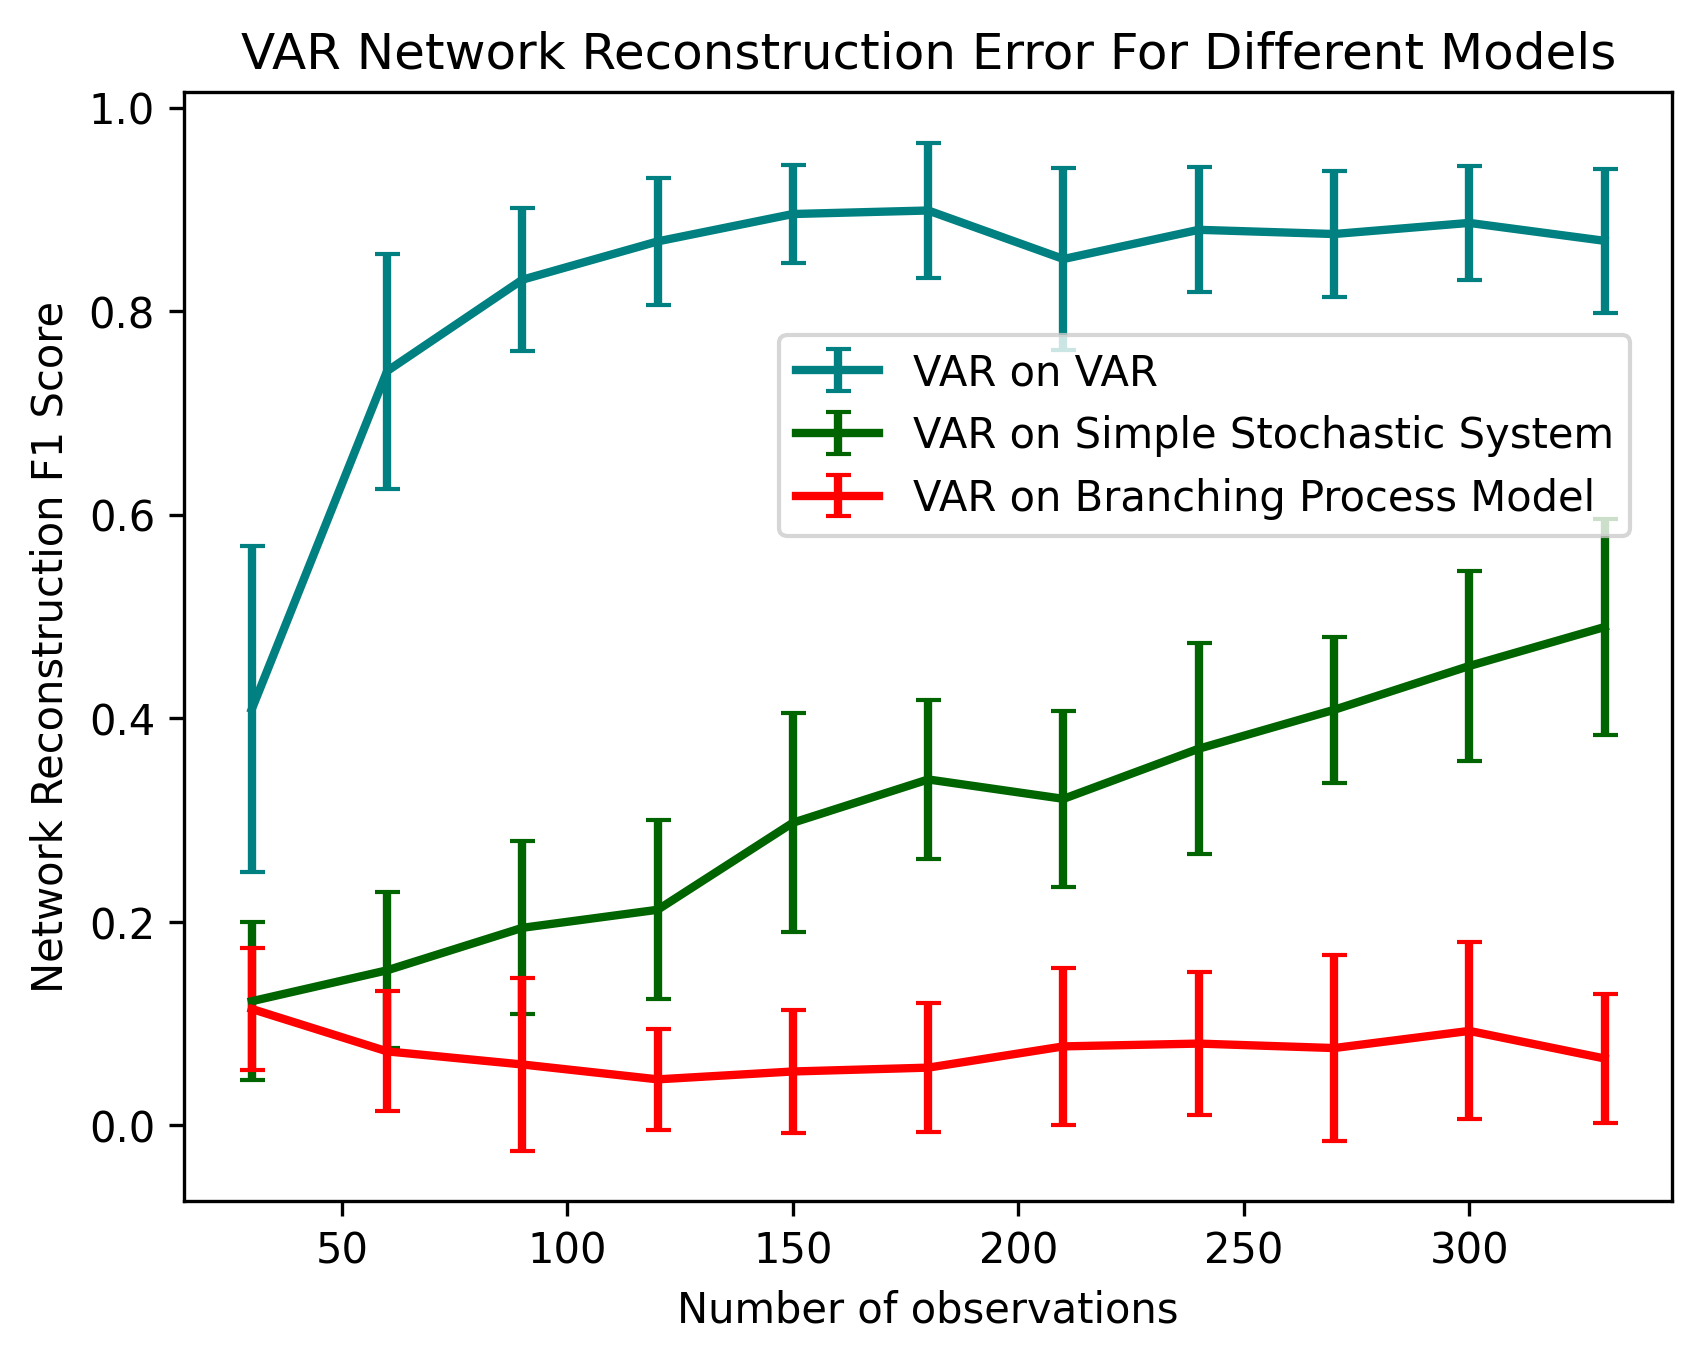

In [8]:
plt.errorbar(obs_seq, mean_f1_qs_var1, yerr=qs_std1, lw=2, capsize=3, label="VAR on VAR", color="teal")
plt.errorbar(obs_seq, mean_f1_qs_var2, yerr=qs_std2, lw=2, capsize=3, label="VAR on Simple Stochastic System", color="darkgreen")
plt.errorbar(obs_seq, mean_f1_branch_var, yerr=branch_std, lw=2, capsize=3, label="VAR on Branching Process Model", color="red")
plt.xlabel("Number of observations")
plt.ylabel("Network Reconstruction F1 Score")
plt.title("VAR Network Reconstruction Error For Different Models")
plt.legend(loc=(0.4, 0.6))
plt.show()

In [9]:
# VAR Simulation

fpr_qs_var_trials1 = [
    graph_inf_score_as_obs_incr(
        obs_seq, graph_model,
        qspems_model1,
        var_infr,
        metrics.compare_adj_false_positive_rate
    )
    for i in range(reps)
]

# Stochastic Difference equation

fpr_qs_var_trials2 = [
    graph_inf_score_as_obs_incr(
        obs_seq,
        graph_model,
        qspems_model2,
        var_infr,
        metrics.compare_adj_false_positive_rate
    )
    for i in range(reps)
]

# Branching process model

fpr_branch_var_trials= [
    graph_inf_score_as_obs_incr(
        obs_seq,
        graph_model,
        branch_model,
        var_infr,
        metrics.compare_adj_false_positive_rate
    )
    for i in range(reps)
]

mean_fpr_qs_var1 = np.mean(np.vstack(fpr_qs_var_trials1), axis=0)
qs_fpr_std1 = np.std(np.vstack(fpr_qs_var_trials1), axis=0)

mean_fpr_qs_var2 = np.mean(np.vstack(fpr_qs_var_trials2), axis=0)
qs_fpr_std2 = np.std(np.vstack(fpr_qs_var_trials2), axis=0)

mean_fpr_branch_var = np.mean(np.vstack(fpr_branch_var_trials), axis=0)
branch_fpr_std = np.std(np.vstack(fpr_branch_var_trials), axis=0)

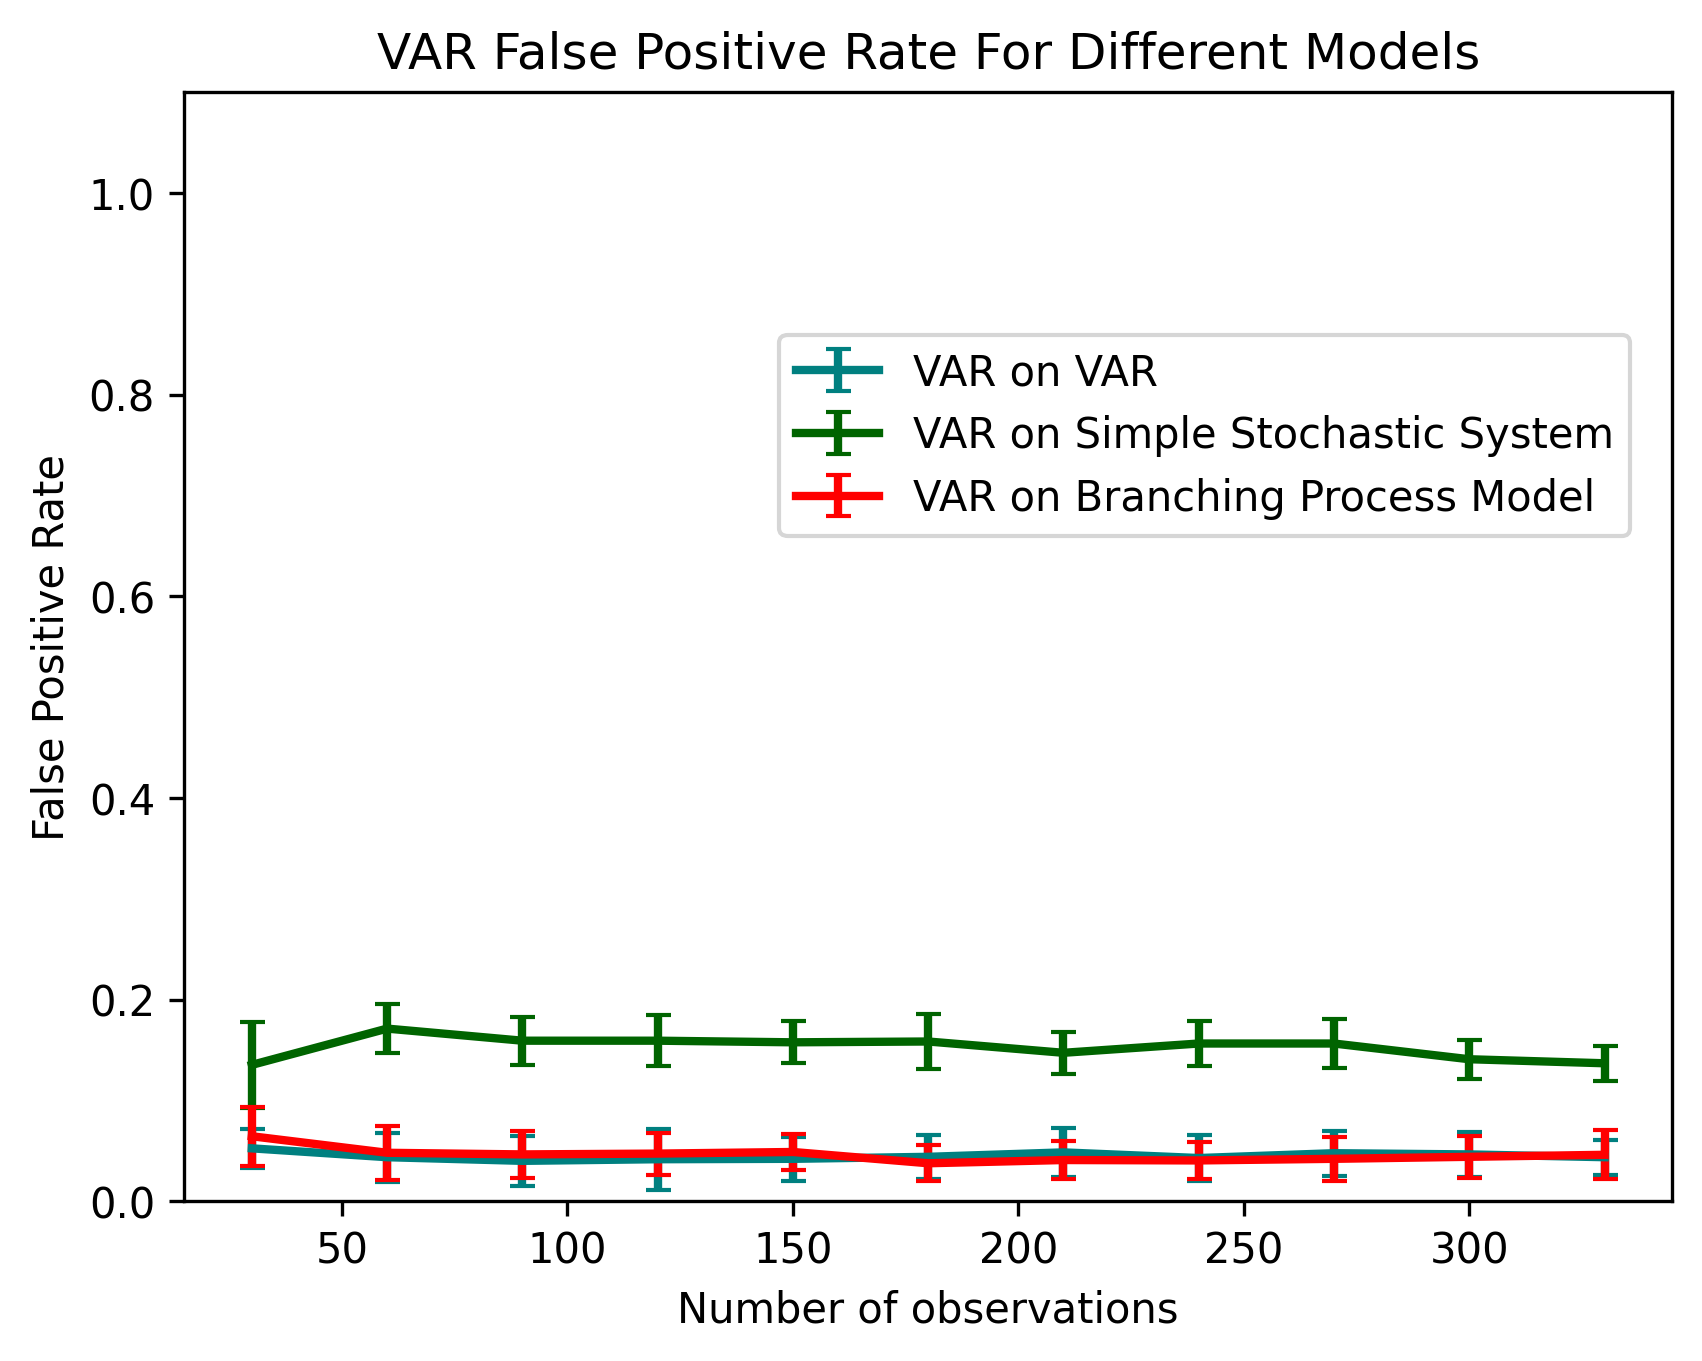

In [10]:
plt.errorbar(obs_seq, mean_fpr_qs_var1, yerr=qs_fpr_std1, lw=2, capsize=3, label="VAR on VAR", color="teal")
plt.errorbar(obs_seq, mean_fpr_qs_var2, yerr=qs_fpr_std2, lw=2, capsize=3, label="VAR on Simple Stochastic System", color="darkgreen")
plt.errorbar(obs_seq, mean_fpr_branch_var, yerr=branch_fpr_std, lw=2, capsize=3, label="VAR on Branching Process Model", color="red")
plt.xlabel("Number of observations")
plt.ylabel("False Positive Rate")
plt.ylim(0, 1.1)
plt.title("VAR False Positive Rate For Different Models")
plt.legend(loc=(0.4, 0.6))
plt.show()